# Deep Learning Home Assignment
# Alireza Bolhassani

----
### Download data and images from google drive 

In [22]:
!wget "https://drive.google.com/u/0/uc?id=1RwL4NeJuw9jmmzILn67P50KfRYaRN12S&export=download" -O imgs.zip
!unzip imgs.zip

!wget "https://drive.google.com/u/0/uc?id=131r_ha4-2_g-igVwsjPB4noA9X1b6gdc&export=download" -O groundtruth.tsv

from IPython.display import clear_output
clear_output(wait=False)


----
### Introduction
In this project, I have developed a machine learning model to classify the Real Sense depth image dataset into two classes.

The model was trained on the Real Sense depth image dataset using a deep learning framework, and its performance was evaluated using various metrics such as training accuracy and loss, confusion matrix, macro-averaged precision and recall, and Precision-Recall curve. These evaluations provide insights into the model's classification performance, convergence behavior during training, and trade-off between precision and recall.

In [23]:
import pandas as pd

groundtruth = pd.read_csv("groundtruth.tsv", delimiter="\t")
groundtruth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2909 entries, 0 to 2908
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     2909 non-null   object
 1   ad_clicked  2909 non-null   int64 
 2   attention   2909 non-null   int64 
 3   log_id      2909 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 91.0+ KB


In [24]:
groundtruth.head(3)

,user_id,ad_clicked,attention,log_id
0,5npsk114ba8hfbj4jr3lt8jhf5,0,4,20181002033126
1,5o9js8slc8rg2a8mo5p3r93qm0,1,5,20181001211223
2,pi17qjfqmnhpsiahbumcsdq0r6,0,4,20181001170952


----
### Generating lists to store the filenames.

Classes includes:
- list_of_class1 is related to clicked ads.
- list_of_class0 is related to not click on ads.

All photos are added to the dataset after resizing.

In [25]:
import os

image_list = os.listdir("imgs")

list_of_class1 = []
list_of_class0 = []

for _, row in groundtruth.iterrows():
    if str(row["log_id"]) + ".png" in image_list:
        if row["ad_clicked"]:
            list_of_class1.append(row["log_id"])
        else:
            list_of_class0.append(row["log_id"])
            
len(list_of_class1), len(list_of_class0)

(494, 1270)

---
### Creating labels and assign to lists 
I create label arrays labels1, and labels0 by using np.ones() and np.zeros() functions to assign labels to the corresponding lists list_of_class1, and list_of_class0. I also concatenate these label arrays using np.concatenate() function along the 0-axis to create a single labels array that represents the labels for all the image files.

In [26]:
import numpy as np

labels1 = np.ones(len(list_of_class1))
labels0 = np.zeros(len(list_of_class0))
labels = np.concatenate((labels1, labels0), axis=0)

len(labels)

1764

---
### Dimensions of images
I create an empty list called dataset to store the data from the images. I also define the desired dimensions of the images as 500 x 500 pixels and store it in a tuple called dim.

In [27]:
dataset = []
dim = (100, 100)

---
### Iterating through the images in lists

In [28]:
import cv2

for img in list_of_class1:
  image = cv2.imread(f"imgs/{img}.png")
  resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
  dataset.append(resized)
for img in list_of_class0:
  image = cv2.imread(f"imgs/{img}.png")
  resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
  dataset.append(resized)

---
### Displaying some pictures
In the below cell, I generate a grid of 3x3 subplots using matplotlib. Each subplot displays an image from the dataset using plt.imshow. The plot is then displayed using plt.show().

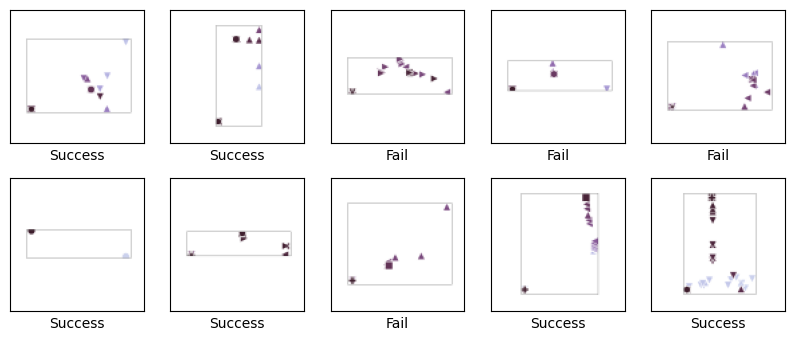

In [29]:
import matplotlib.pyplot as plt

names = ["Success", "Fail"]
random = np.random.randint(len(dataset), size=10)
plt.figure(figsize=(10,4))
i = 1
for n in random:
    plt.subplot(2, 5, i)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(dataset[n], cmap=plt.cm.binary)
    plt.xlabel(names[int(labels[n])])
    i += 1
plt.show()

---
### Converting to NumPy array, Split to training, validation and test sets

In the following, It converts the dataset and labels into NumPy arrays and then partitions them into training, validation, and test sets using the train_test_split function. The test set constitutes 20% of the original dataset, while the training and validation sets are split into 75% and 25% portions, respectively. The code concludes by displaying the shapes of the training, validation, and test sets, providing a concise overview of their dimensions.

- 80 percent of data for training.
- 75 percentage of the 20 percentage of remaining data is used as validation data.
- The rest of data is considered as a test data set 

In [30]:
from sklearn.model_selection import train_test_split

dataset = np.array(dataset)
labels = np.array(labels)

X_trainvald, X_test, y_trainvald, y_test = train_test_split(dataset, labels, test_size=0.20, random_state=42)
X_train, X_vald, y_train, y_vald = train_test_split(X_trainvald, y_trainvald, test_size=0.25, random_state=42)

# Data scaling
X_trainvald = X_trainvald / 255
X_train = X_train / 255
X_vald = X_vald / 255

print("Training shape:", X_train.shape)
print("Validation shape:", X_vald.shape)
print("Test shape:", X_test.shape)

Training shape: (1058, 100, 100, 3)
Validation shape: (353, 100, 100, 3)
Test shape: (353, 100, 100, 3)


In [31]:
# display the shapes
shapes = [
    [X_trainvald.shape, y_trainvald.shape],
    [X_train.shape, y_train.shape],
    [X_test.shape, y_test.shape],
]
shape = pd.DataFrame(shapes, columns=["X", "y"], index=["Train", "Validation", "Test"])
shape

,X,y
Train,"(1411, 100, 100, 3)","(1411,)"
Validation,"(1058, 100, 100, 3)","(1058,)"
Test,"(353, 100, 100, 3)","(353,)"


----
### Clear Session

In [32]:
from tensorflow.keras import backend 
import tensorflow as tf

tf.random.set_seed(42)
backend.clear_session()

----
### Create Convolutional Neural Network Model

layers.Dense(1, activation='sigmoid')
- 1: Single neuron because it's a binary classification task.
- activation='sigmoid': Sigmoid activation function is used for binary classification, mapping the output to a value between 0 and 1.

In [33]:
from tensorflow.keras import layers, models, regularizers

input_tensor = layers.Input(shape=(dim[0], dim[1], 3))

################### Conv layer one #######################
conv1 = layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l1(0.01))(input_tensor)
maxpool1 = layers.MaxPooling2D((2, 2))(conv1)
dropout1 = layers.Dropout(0.25)(maxpool1)

################### Conv layer two #######################
conv2 = layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l1(0.01))(dropout1)
maxpool2 = layers.MaxPooling2D((2, 2))(conv2)
dropout2 = layers.Dropout(0.25)(maxpool2)

conv3 = layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l1(0.01))(dropout2)
maxpool3 = layers.MaxPooling2D((2, 2))(conv3)

################### Convert tensors to vectors #######################
flatten = layers.Flatten()(maxpool3)

dense1 = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1(0.01))(flatten)
dropout3 = layers.Dropout(0.5)(dense1)

n_classes = len(np.unique(labels)) 
output_tensor = layers.Dense(n_classes, activation='sigmoid')(dropout3)
modeling = models.Model(inputs=input_tensor, outputs=output_tensor)

In [34]:
modeling.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 49, 49, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 49, 49, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                        

----
### Compiling
In the following cell, the code prepares the model for training by compiling it with the modeling variable.

In [35]:
modeling.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In the next cell, with the ModelCheckpoint function, it makes a model checkpoint callback that saves the best model weights to a file called ‘my_model.keras’ during the training process. 

In [36]:
from tensorflow.keras.callbacks import ModelCheckpoint

checking = ModelCheckpoint('my_model.keras', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

In [37]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

---
### Fitting the model
The epoch parameter in neural network training is a hyperparameter that represents the number of times the entire training dataset is used to update the model weights. Each epoch consists of one or more batches, which are subsets of the training data that are processed in each iteration.

In [38]:
epochs = 100
batch_size = 64
history = modeling.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_vald, y_vald), callbacks=[early_stop, checking])

Epoch 1/100
17/17 [==============================] - ETA: 0s - loss: 113.6609 - accuracy: 0.7023
Epoch 1: val_accuracy improved from -inf to 0.71955, saving model to my_model.keras
17/17 [==============================] - 14s 756ms/step - loss: 113.6609 - accuracy: 0.7023 - val_loss: 41.9360 - val_accuracy: 0.7195
Epoch 2/100
17/17 [==============================] - ETA: 0s - loss: 30.2076 - accuracy: 0.7231
Epoch 2: val_accuracy did not improve from 0.71955
17/17 [==============================] - 12s 704ms/step - loss: 30.2076 - accuracy: 0.7231 - val_loss: 17.3010 - val_accuracy: 0.7195
Epoch 3/100
17/17 [==============================] - ETA: 0s - loss: 12.3394 - accuracy: 0.7231
Epoch 3: val_accuracy did not improve from 0.71955
17/17 [==============================] - 12s 723ms/step - loss: 12.3394 - accuracy: 0.7231 - val_loss: 7.5906 - val_accuracy: 0.7195
Epoch 4/100
17/17 [==============================] - ETA: 0s - loss: 5.8101 - accuracy: 0.7231
Epoch 4: val_accuracy did no

----
### Printing accuracy and loss by evaluate method
In the following cell, I print the accuracy and loss values obtained from evaluating the model on the test dataset.

In [39]:
loss, accuracy = modeling.evaluate(X_test, y_test)

print("Accuracy:", accuracy, "Loss:", loss)

12/12 [==============================] - 1s 70ms/step - loss: 2.6851 - accuracy: 0.7110
Accuracy: 0.7110481858253479 Loss: 2.6850523948669434


---
### Model Accuracy and Loss plot

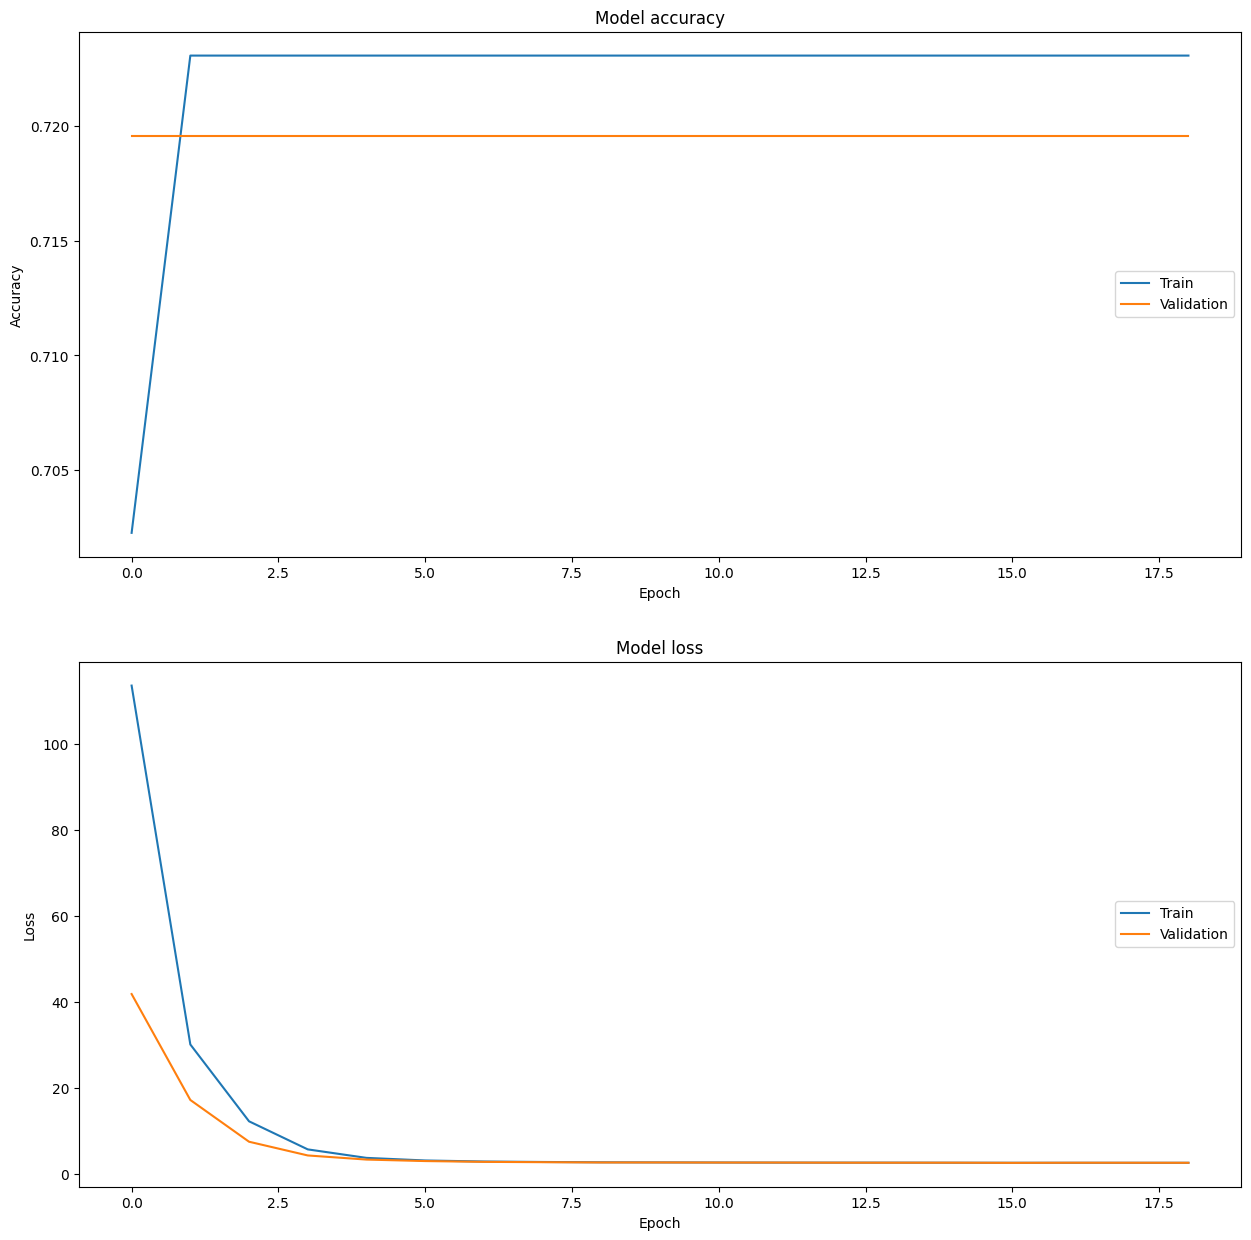

In [40]:
fig, axis = plt.subplots(2, 1, figsize=(15, 15))

axis[0].plot(history.history['accuracy'])
axis[0].plot(history.history['val_accuracy'])
axis[0].set_title('Model accuracy')
axis[0].set_ylabel('Accuracy')
axis[0].set_xlabel('Epoch')
axis[0].legend(['Train', 'Validation'], loc='center right')

axis[1].plot(history.history['loss'])
axis[1].plot(history.history['val_loss'])
axis[1].set_title('Model loss')
axis[1].set_ylabel('Loss')
axis[1].set_xlabel('Epoch')
axis[1].legend(['Train', 'Validation'], loc='center right')

plt.show()

----
### Evaluation using Confusion Matrix
The following code generates a confusion matrix using the seaborn library to evaluate the performance of a trained model. 

12/12 [==============================] - 1s 81ms/step


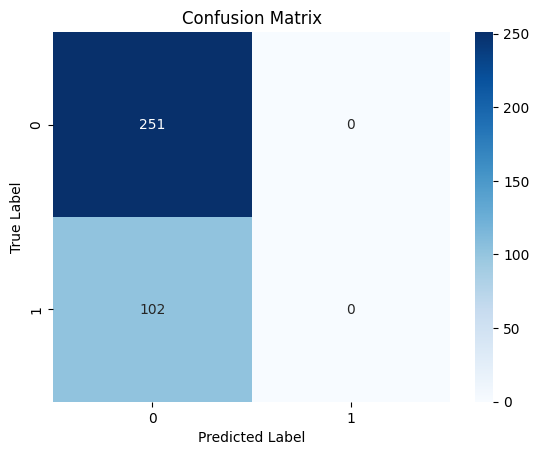

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_prob = modeling.predict(X_test)
y_pred = np.argmax(y_prob, axis=1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

----
### Precision Recall Curve

12/12 [==============================] - 1s 68ms/step


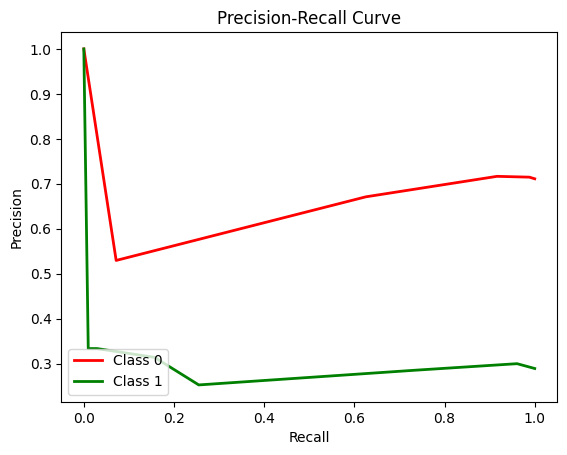

In [42]:
from sklearn.metrics import precision_recall_curve, precision_score, recall_score
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_prob = modeling.predict(X_test)
precision = dict()
recall = dict()
for i in range(2):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_prob[:, i])
plt.figure()
for i, color in zip(range(2), ['red', 'green']):
    plt.plot(recall[i], precision[i], color=color, lw=2, label='Class {}'.format(i))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


-----
### Conclusion
Unfortunately, the results are not acceptable, even though the parameters of the model have been studied a lot, but the results are still weak. According to the investigation carried out, I consider two possible reasons for it.

First, the amount of information for an artificial intelligence network is not only not enough, but it is not even symmetrical. It means that the information is somehow not balanced.

Secondly, it seems that the prediction of the result does not have a specific logic and pattern that can be classified in the form of artificial intelligence.